In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [4]:
!python -m pip install scipy

In [5]:
filename = 'Event_Row_1_Data_zero_order_interpolation.csv'
sheet_name = 'Event_Row_1_Data_zero_order_int'
df = pd.read_csv(filename)

In [6]:
df.head()

,Relative Time (sec),Time,GE - ABP S 1,GE - ABP D 1,GE - CVP M 2,GE - RR (imp) 1,GE - SpO2 1,GE - NBP S,GE - NBP M,GE - NBP D,GE - EtCO₂,GE - RR (vent),GE - ECG II,GE - PLETH 1,GE - ABP 1,GE - CVP 2
0,0.061341,2024-01-15 13:00:00.061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.02550,156.0,86.8,12.0
1,0.065524,2024-01-15 13:00:00.065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.04335,156.0,86.8,12.0
2,0.069708,2024-01-15 13:00:00.069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05610,156.0,87.6,12.0
3,0.073891,2024-01-15 13:00:00.073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05865,156.0,87.6,12.0
4,0.078074,2024-01-15 13:00:00.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05610,197.2,88.2,12.0


In [7]:
df = df.drop(['GE - ABP S 1','GE - ABP D 1', 'GE - CVP M 2',
              'GE - RR (imp) 1', 'GE - SpO2 1', 'GE - NBP S',
              'GE - NBP M', 'GE - NBP D', 'GE - RR (vent)',
              'GE - PLETH 1', 'GE - ABP 1', 'GE - CVP 2'], axis=1)
df = df.drop(df.columns[2], axis=1)
df.head()

,Relative Time (sec),Time,GE - ECG II
0,0.061341,2024-01-15 13:00:00.061,-0.02550
1,0.065524,2024-01-15 13:00:00.065,-0.04335
2,0.069708,2024-01-15 13:00:00.069,-0.05610
3,0.073891,2024-01-15 13:00:00.073,-0.05865
4,0.078074,2024-01-15 13:00:00.078,-0.05610


In [8]:
df['Time'] = pd.to_datetime(df['Time'])
initial = df.loc[0,'Relative Time (sec)']
df['relTimeNew'] = df['Relative Time (sec)']-initial
df.head()

,Relative Time (sec),Time,GE - ECG II,relTimeNew
0,0.061341,2024-01-15 13:00:00.061,-0.02550,0.000000
1,0.065524,2024-01-15 13:00:00.065,-0.04335,0.004183
2,0.069708,2024-01-15 13:00:00.069,-0.05610,0.008367
3,0.073891,2024-01-15 13:00:00.073,-0.05865,0.012550
4,0.078074,2024-01-15 13:00:00.078,-0.05610,0.016733


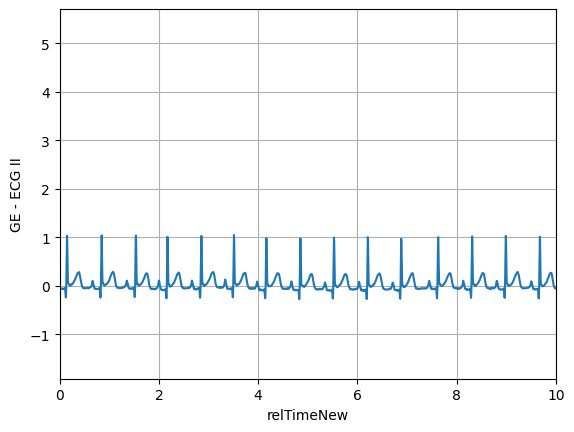

In [9]:
plt.plot(df['relTimeNew'],df['GE - ECG II'])
plt.xlim(0,10)
# plt.ylim(-1,2)
plt.xlabel('relTimeNew')
plt.ylabel('GE - ECG II')
plt.grid(True)
plt.show()

In [10]:
print(df['relTimeNew'])
print(df['relTimeNew'].iloc[-1])

0              0.000000
1              0.004183
2              0.008367
3              0.012550
4              0.016733
               ...     
3463195    14399.970561
3463196    14399.974756
3463197    14399.978950
3463198    14399.983145
3463199    14399.987339
Name: relTimeNew, Length: 3463200, dtype: float64
14399.987339496613


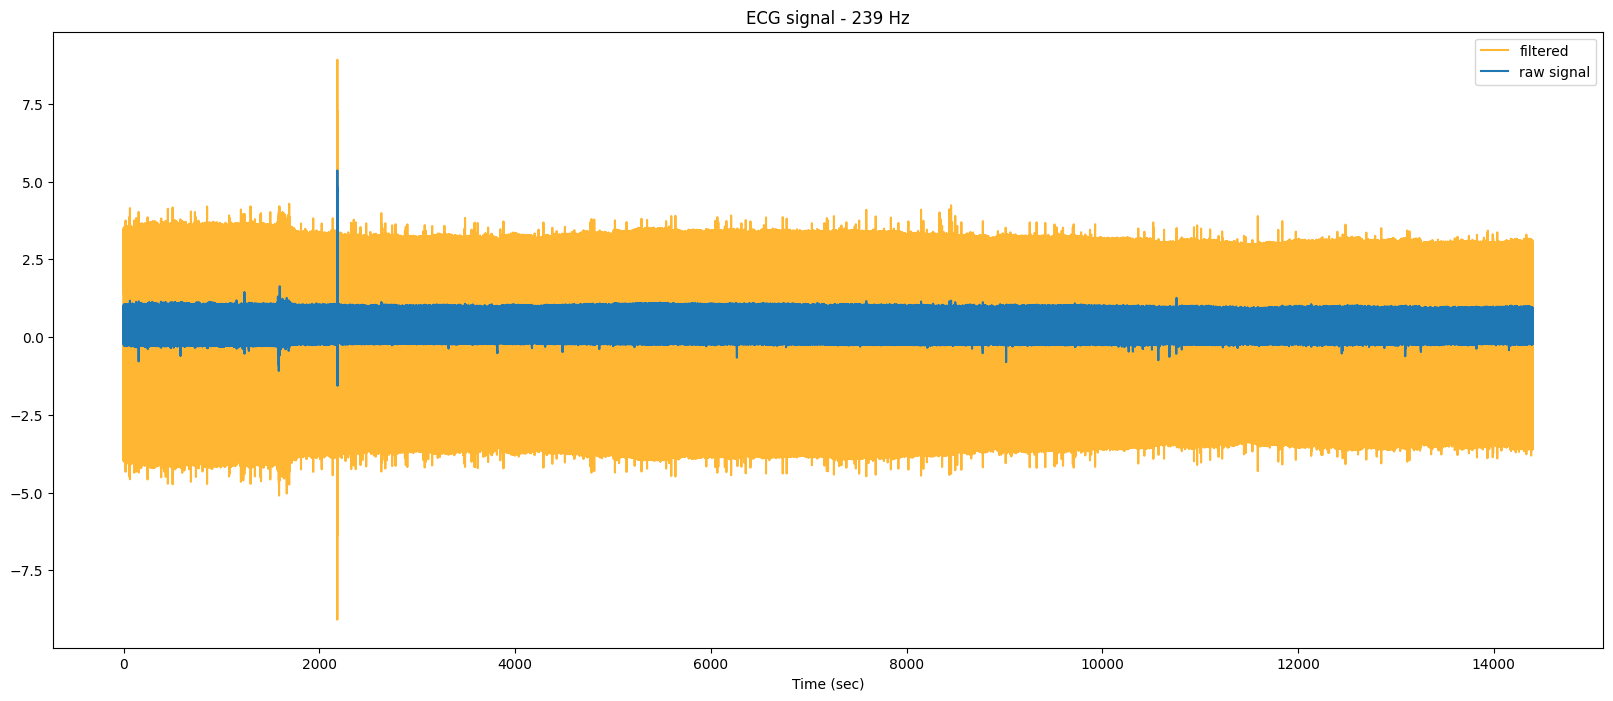

In [11]:
# template match to amplify peaks

# linear spaced vector between 0.5 pi and 1.5 pi 
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# create sine filter for approximating QRS feature
peak_filter = np.sin(v)

# compute cross correlation between ecg and the sine filter
final_sec = 239* int((df['relTimeNew'].iloc[-1]))
ecg_transformed = np.correlate(df['GE - ECG II'][0:final_sec], peak_filter, mode="same")

# and plot the raw + filtered signal

x = np.linspace(0,int((df['relTimeNew'].iloc[-1])),final_sec)

plt.figure(figsize=(20,8))
plt.title('ECG signal - 239 Hz')
plt.plot(x,ecg_transformed[0:final_sec], alpha = 0.8, c='orange')
plt.plot(x,df['GE - ECG II'][0:final_sec], alpha = 1)
plt.gca().legend(('filtered','raw signal'))
plt.xlabel('Time (sec)')
plt.show()

[     40     204     367 ... 3440983 3441158 3441329]


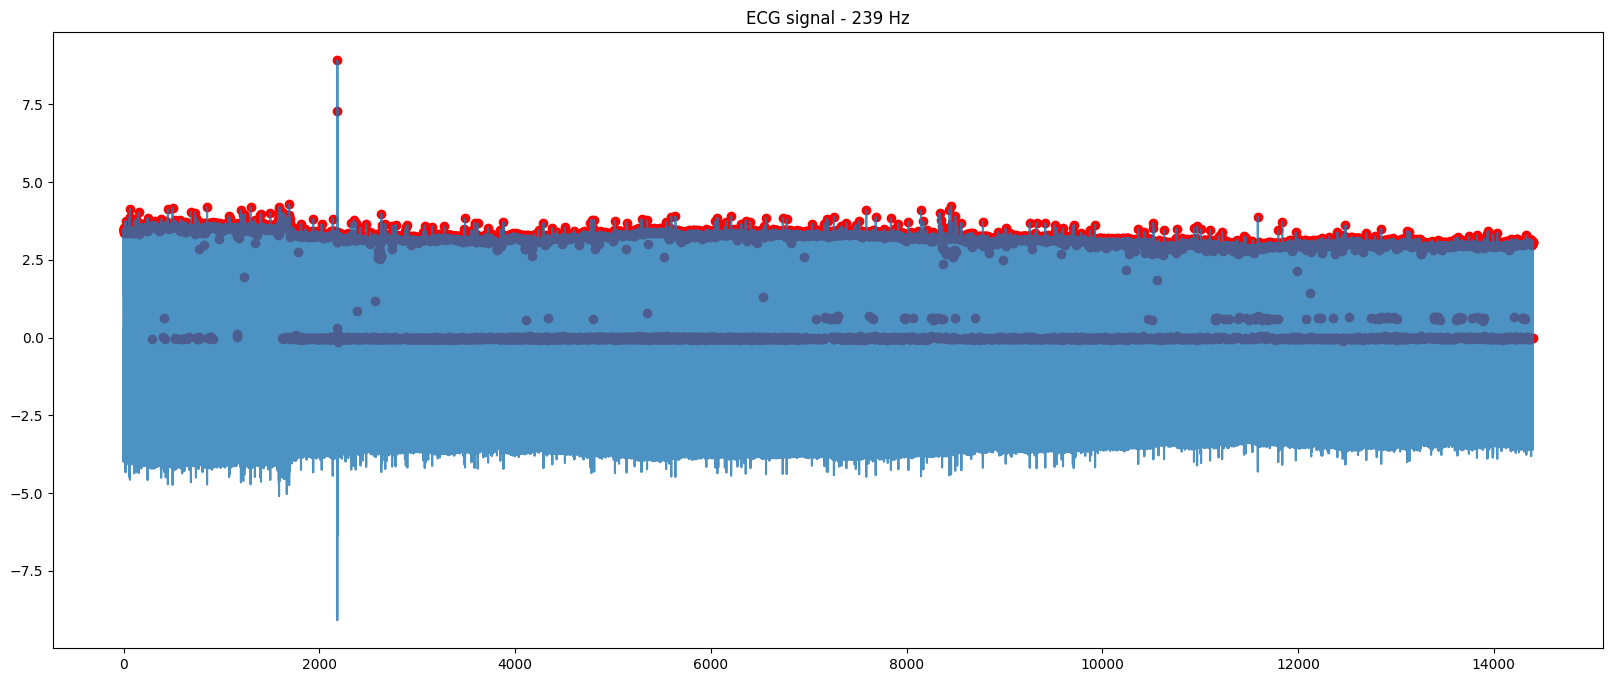

In [13]:
# calculates the differences between consecutive samples
diff_sig_ecg = np.diff(df['GE - ECG II'])

rr_peaks, _ = find_peaks(ecg_transformed, distance=239*(30/60))
print(rr_peaks)

plt.figure(figsize=(20,8))
plt.plot(x, ecg_transformed, alpha = 0.8)
plt.scatter(rr_peaks/239, ecg_transformed[rr_peaks], color='red')
#plt.xlim(0,df['GE - ECG II'][0:final_sec])
plt.title("ECG signal - 239 Hz")
plt.show()

[0.68619247 0.68200837 0.66527197 ... 0.79916318 0.73221757 0.71548117]


<Figure size 1000x600 with 0 Axes>

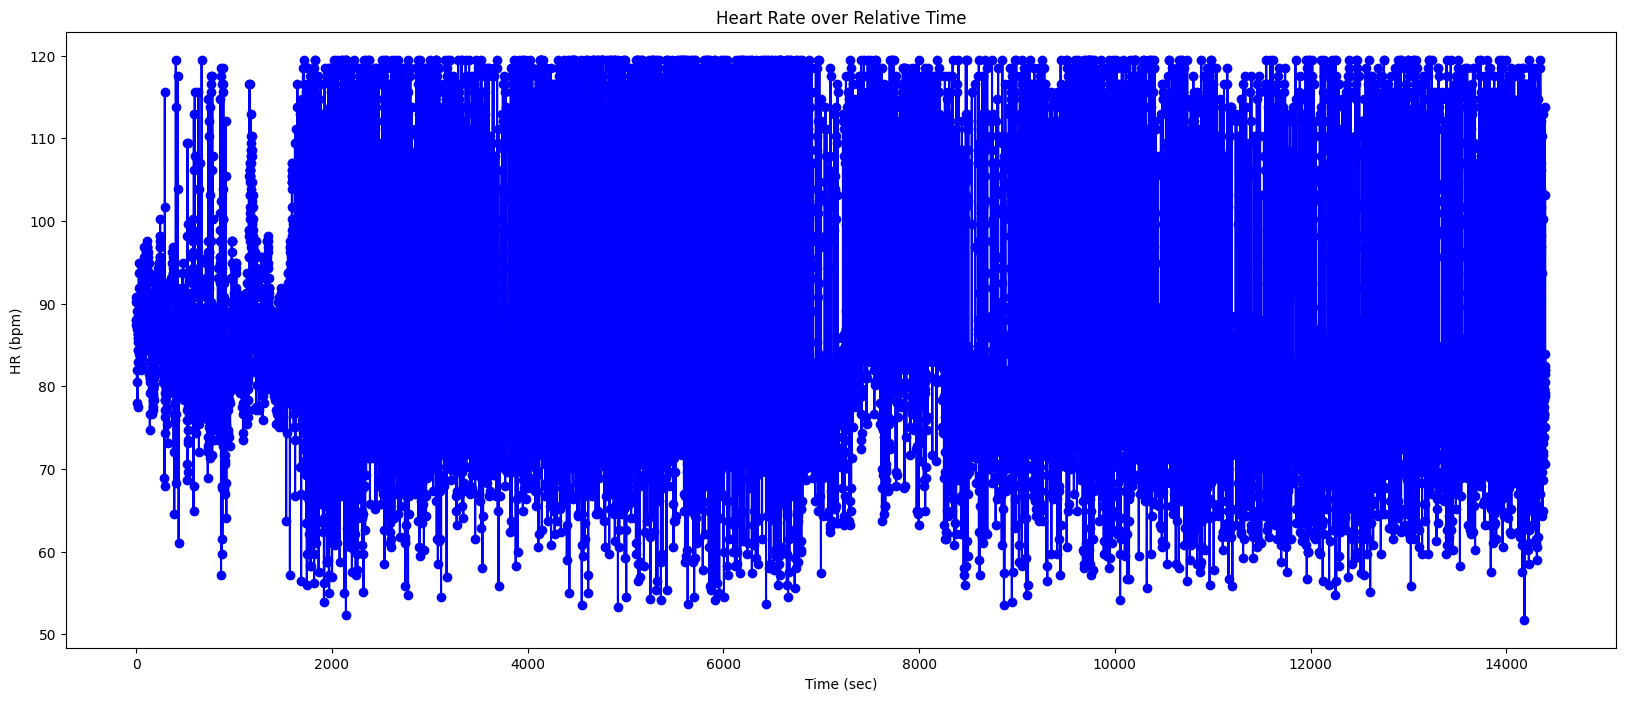

In [18]:
rr_int = np.diff(rr_peaks) / 239 # assume 239 Hz is sampling rate
print(rr_int)
hr = [60/rr for rr in rr_int]
plt.figure(figsize=(10, 6))
x_start = rr_peaks[1]/239
x_end = rr_peaks[-1]/239
x = [i/239 for i in rr_peaks[1:]]

plt.figure(figsize=(20,8))
plt.plot(x, hr, marker='o', color='blue')  # Use rr_peaks[:-1] to match the length of hr
#plt.xlim(0, 10)  # Adjust x-axis limit to match ECG signal
plt.title("Heart Rate over Relative Time")
plt.xlabel("Time (sec)")
plt.ylabel("HR (bpm)")
plt.show()
